In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return pd.Series(result)

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return pd.Series(result)

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    E = 0
    E_y = 0
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(y_value)
    plt.grid(True)
    plt.plot(x_value, y_value, "o")
    k, b = mnk_non_zero(x_value, y_value)
    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin,xmax])
    print(type(xl))
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)

    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    E = 0
    E_y = 0
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(x_value)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)

    print("k, b =", k, b)
    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



<>:236: SyntaxWarning: invalid escape sequence '\p'
<>:239: SyntaxWarning: invalid escape sequence '\p'
<>:241: SyntaxWarning: invalid escape sequence '\p'
<>:241: SyntaxWarning: invalid escape sequence '\c'
<>:244: SyntaxWarning: invalid escape sequence '\p'
<>:236: SyntaxWarning: invalid escape sequence '\p'
<>:239: SyntaxWarning: invalid escape sequence '\p'
<>:241: SyntaxWarning: invalid escape sequence '\p'
<>:241: SyntaxWarning: invalid escape sequence '\c'
<>:244: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_20744\3581622266.py:236: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_20744\3581622266.py:239: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_20744\3581622266.py:241: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10

In [31]:
data1 = pd.read_csv("data1.csv")
data1


,Index,Time(s),Volt(V)
0,1,0.000,1.44
1,2,0.002,1.44
2,3,0.004,1.44
3,4,0.006,1.48
4,5,0.008,1.48
...,...,...,...
3995,3996,7.990,1.72
3996,3997,7.992,1.76
3997,3998,7.994,1.78
3998,3999,7.996,1.72


In [32]:
data2 = pd.read_csv("data2.csv")
data = pd.DataFrame()
data["T"] = data1["Time(s)"]
data["V1"] =data1["Volt(V)"]
data["V2"] = data2["Volt(V)"]
data

,T,V1,V2
0,0.000,1.44,-1.24
1,0.002,1.44,-1.24
2,0.004,1.44,-1.28
3,0.006,1.48,-1.28
4,0.008,1.48,-1.28
...,...,...,...
3995,7.990,1.72,-0.36
3996,7.992,1.76,-0.36
3997,7.994,1.78,-0.36
3998,7.996,1.72,-0.36


In [62]:
#L = 1063.663 + 0.01(triangle(0.4t))

def triangle_wave(x, T=1):
    x = x % T  # Переводим x в диапазон одного периода [0, T)
    if x < T / 2:
        return 2 * x / T  # Линейный рост от 0 до 1
    else:
        return 2 - 2 * x / T  # Линейное падение от 1 до 0



V2_max = max(data["V2"])
V2_min = min(data["V2"])
print(V2_max, V2_min)
data["L"] = 1063.663 + 0.01*(data["V2"]-V2_min)/(V2_max-V2_min) 
data["L2"] = 1063.663 + 0.01*data["T"].apply(lambda x : triangle_wave(x,2))

data


0.84 -1.32


,T,V1,V2,L,V_new,L2
0,0.000,1.44,-1.24,1063.663370,$-0.13 \pm 1.00$,1063.66300
1,0.002,1.44,-1.24,1063.663370,$-0.13 \pm 1.00$,1063.66302
2,0.004,1.44,-1.28,1063.663185,$-0.14 \pm 1.00$,1063.66304
3,0.006,1.48,-1.28,1063.663185,$-0.10 \pm 1.00$,1063.66306
4,0.008,1.48,-1.28,1063.663185,$-0.10 \pm 1.00$,1063.66308
...,...,...,...,...,...,...
3995,7.990,1.72,-0.36,1063.667444,$0.29 \pm 1.00$,1063.66310
3996,7.992,1.76,-0.36,1063.667444,$0.33 \pm 1.00$,1063.66308
3997,7.994,1.78,-0.36,1063.667444,$0.35 \pm 1.00$,1063.66306
3998,7.996,1.72,-0.36,1063.667444,$0.29 \pm 1.00$,1063.66304


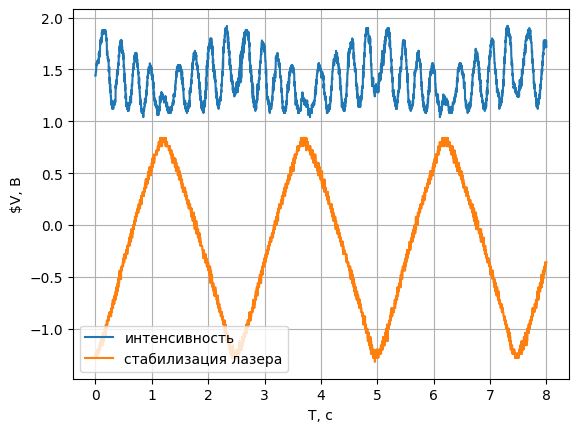

In [34]:
plt.xlabel("T, с")
plt.ylabel("$V, В")
plt.grid(True)
plt.plot(data["T"], data["V1"], label = "интенсивность")
plt.plot(data["T"], data["V2"], label = "стабилизация лазера")
plt.legend()
plt.savefig("graph1.png", dpi=300)


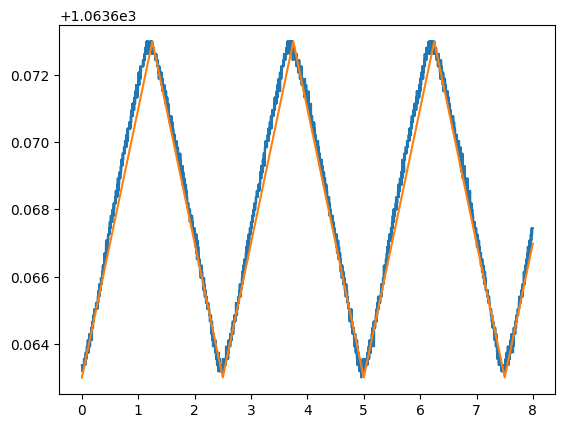

In [65]:
def triangle_wave(x, T=1):
    x = x % T  # Переводим x в диапазон одного периода [0, T)
    if x < T / 2:
        return 2 * x / T  # Линейный рост от 0 до 1
    else:
        return 2 - 2 * x / T  # Линейное падение от 1 до 0


data["L2"] = 1063.663 + 0.01*data["T"].apply(lambda x : triangle_wave(x,2.5))


plt.plot(data["T"], data["L"])
plt.plot(data["T"], data["L2"])

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_20744\3429913616.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda_{vac}$, нм")


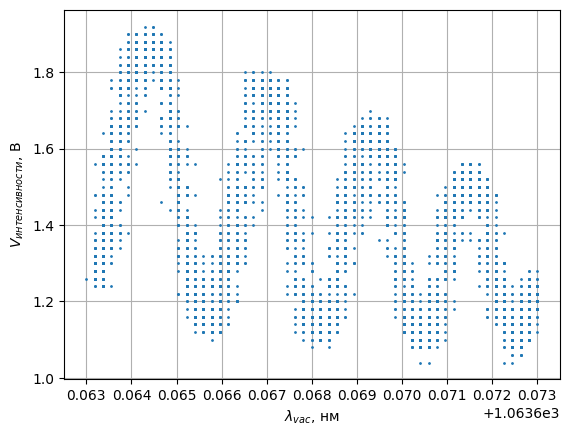

In [ ]:
import matplotlib.ticker


data_srez = data[data["T"]<12]
data_srez = data_srez[data_srez["T"]>0]
data_srez.index = range(len(data_srez))
plt.grid(True)
plt.xlabel("$\lambda_{vac}$, нм")
plt.ylabel("$V_{интенсивности}$, В")

g = plt.gca()
g.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.001))
g.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))
plt.plot(data_srez["L"], data_srez["V1"], "o", ms = 1)

L = 1063 + pd.Series([DData(0.0645,0.002), DData(0.067,0.002), DData(0.0693,0.002), DData(0.0715,0.002)])
plt.savefig("graph2.png", dpi=300)




[-0.3  3.3]
k, b = $0.002330 \pm 0.000047$ $1063.064580 \pm 0.000088$
$51.0 \pm 2.1$ 75.92857142857143


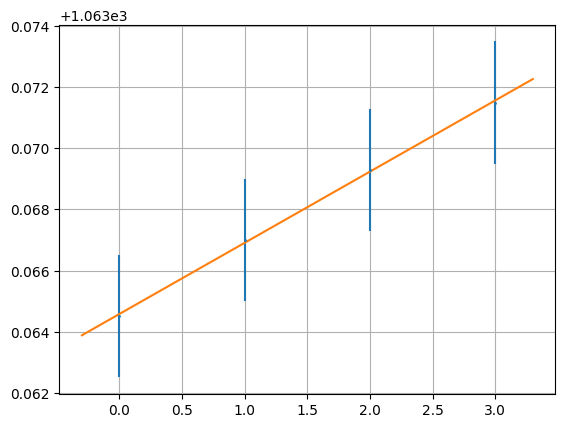

In [124]:
delta_lambda, _ = linearcalc_error(pd.Series([0,1,2,3]), L)
delta_L = delta_lambda**2/data["L2"].mean() * 10**10
delta_L.E = 0
print(delta_L, 1063/14)

<class 'numpy.ndarray'>
k, b = $-36.9 \pm 1.1$ $26.06 \pm 0.74$


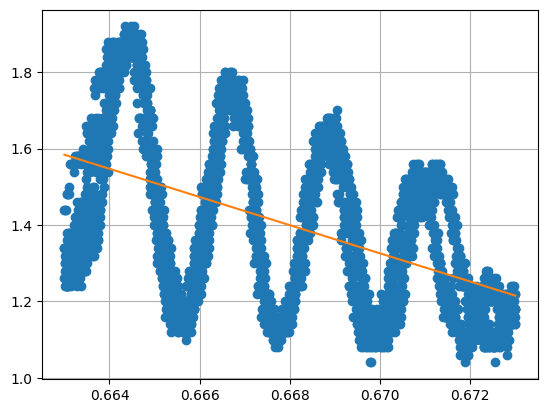

In [69]:
k, b = linearcalc((data["L2"]-1063), data["V1"])

data["V_new"] = data["V1"] - (data["L2"]-1063) * k - b


[1063.6642992 1063.6656048]
k, b = $2191 \pm 29$ $-2331000.0 \pm 31000.0$
$0.002868 \pm 0.000038$
$39.45 \pm 0.53$


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_20744\3581622266.py:243: UserWarning: Что-то сломалось при отображении 
  warnings.warn("Что-то сломалось при отображении ")


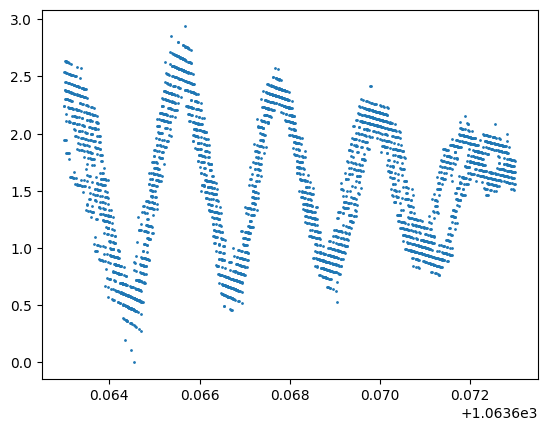

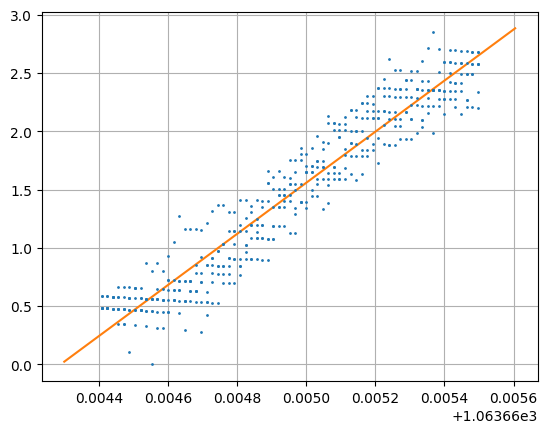

In [113]:
A_max = max(get_values(data["V_new"]))
data_srez_2 = data[data["L2"] > 1063.6644]
data_srez_2.index = range(len(data_srez_2))
data_srez_2 = data_srez_2[data_srez_2["L2"] < 1063.6655]
data_srez_2.index = range(len(data_srez_2))
A_max = max(get_values(data["V_new"]))
plt.plot(data["L2"], np.arccos(get_values(data["V_new"])/A_max/1), "o", ms=1)
plt.figure()
K_e, _ = linearcalc_error(data_srez_2["L2"], np.arccos(get_values(data_srez_2["V_new"])/A_max/1))
dL = 3.142/K_e*2
print(dL)
delta_L_2 = 1063.667**2 / dL / 10**7

print(delta_L_2)